In [1]:
%matplotlib inline
import pylab
import numpy as np
import nengo
import seaborn

:0: FutureWarning: IPython widgets are experimental and may change in the future.


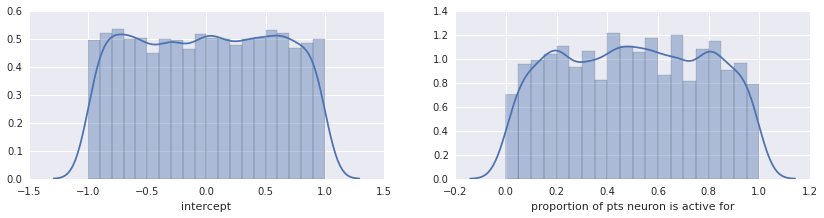

In [33]:
def plot_intercept_distribution(ens):
    pylab.subplot(1,2,1)
    intercepts = ens.intercepts.sample(ens.n_neurons)
    seaborn.distplot(intercepts, bins=20)
    pylab.xlabel('intercept')

    pylab.subplot(1,2,2)
    pts = ens.eval_points.sample(n=1000, d=ens.dimensions)
    model = nengo.Network()
    model.ensembles.append(ens)
    sim = nengo.Simulator(model)
    _, activity = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=pts)
    p = np.mean(activity>0, axis=0)
    seaborn.distplot(p, bins=20)
    pylab.xlabel('proportion of pts neuron is active for')
    
    
ens = nengo.Ensemble(n_neurons=10000, dimensions=1, add_to_container=False)
pylab.figure(figsize=(14,3))   
plot_intercept_distribution(ens)

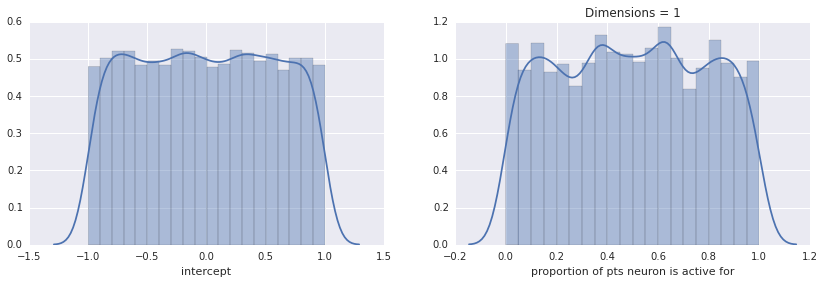

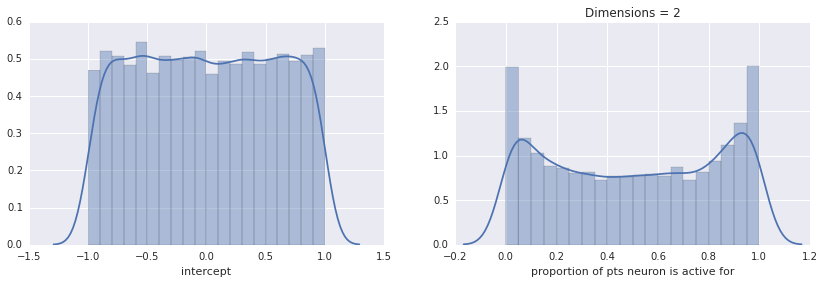

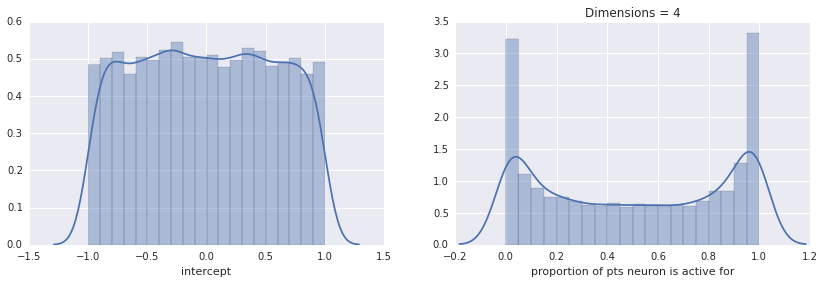

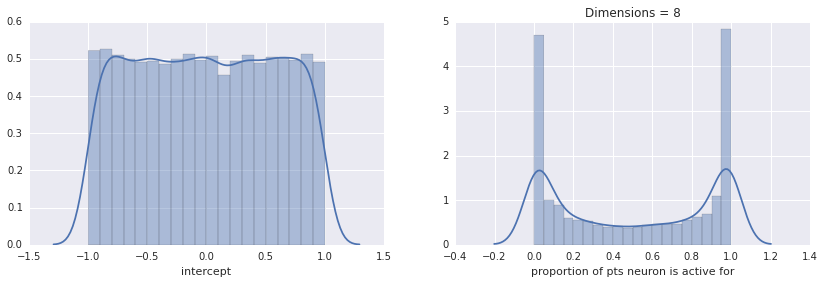

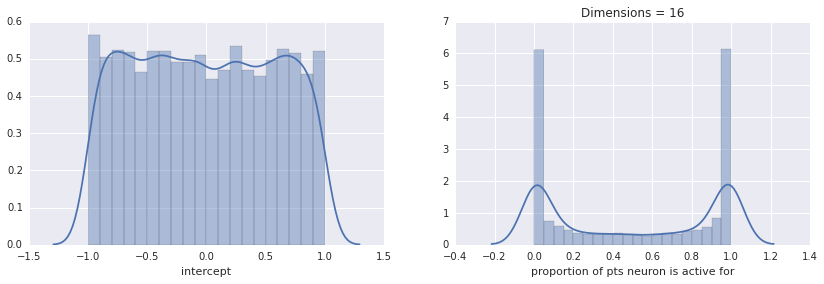

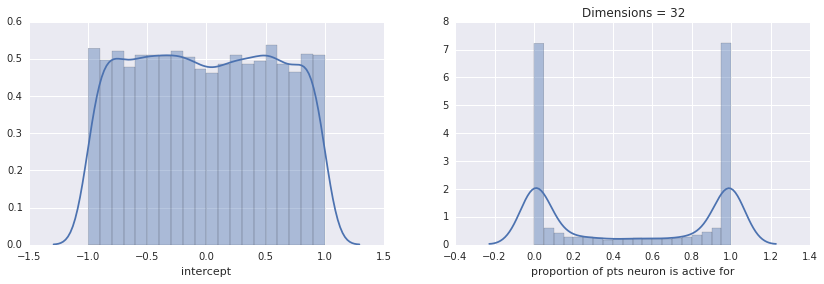

In [34]:
for D in [1, 2, 4, 8, 16, 32]:
    ens = nengo.Ensemble(n_neurons=10000, dimensions=D, add_to_container=False)
    pylab.figure(figsize=(14,4))   
    plot_intercept_distribution(ens)
    pylab.title('Dimensions = %d' % D)

In [56]:
import scipy.special
def analytic_proportion(x, d):
    flip = False
    if x < 0: 
        x = -x
        flip = True
        
    if x >= 1.0:
        value = 0
    else:
        r = np.sqrt(1.0 - x**2)
        h = 1 - x

        I = scipy.special.betainc((d+1)/2.0, 0.5, (2*r*h-h**2)/r**2)
        value = 0.5*(r**d)*I
    
    if flip:
        value = 1.0 - value
    return value
    
print analytic_proportion(-0.5, 1)


0.75


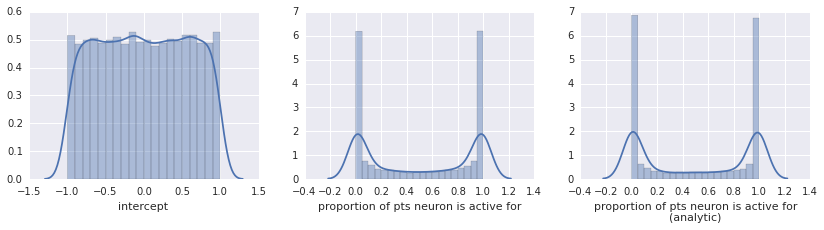

In [80]:
def plot_intercept_distribution(ens):
    pylab.subplot(1,3,1)
    intercepts = ens.intercepts
    if isinstance(intercepts, nengo.dists.Distribution):
        intercepts = intercepts.sample(ens.n_neurons)
    seaborn.distplot(intercepts, bins=20)
    pylab.xlabel('intercept')

    pylab.subplot(1,3,2)
    pts = ens.eval_points.sample(n=1000, d=ens.dimensions)
    model = nengo.Network()
    model.ensembles.append(ens)
    sim = nengo.Simulator(model)
    _, activity = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=pts)
    p = np.mean(activity>0, axis=0)
    seaborn.distplot(p, bins=20)
    pylab.xlabel('proportion of pts neuron is active for')
    
    p2 = [analytic_proportion(x, ens.dimensions) for x in intercepts]
    pylab.subplot(1,3,3)
    seaborn.distplot(p2, bins=20)
    pylab.xlabel('proportion of pts neuron is active for\n(analytic)')
    
    
    
ens = nengo.Ensemble(n_neurons=10000, dimensions=16, add_to_container=False)
pylab.figure(figsize=(14,3))   
plot_intercept_distribution(ens)

In [107]:
def find_x_for_p(p, d):
    def f(x):
        return (analytic_proportion(x, d) - p)**2
    x = scipy.optimize.minimize(f, x0=0, method='Nelder-Mead').x[0]
    return x

print find_x_for_p(0.25, 2)

0.3824375


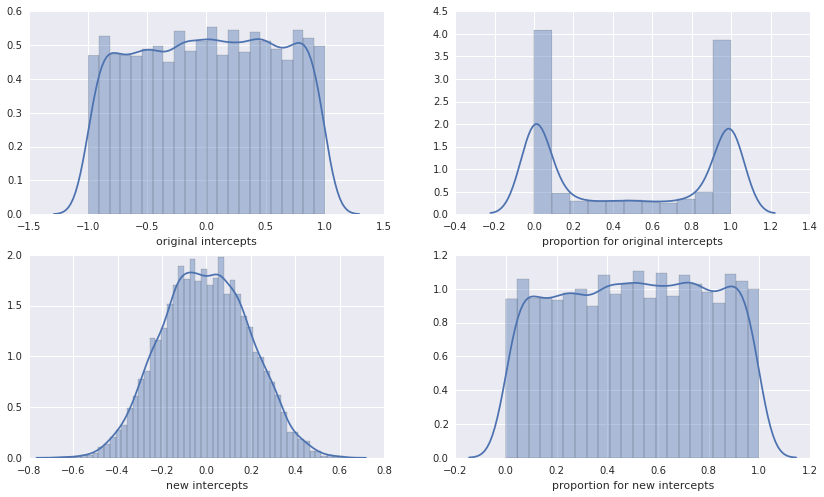

In [111]:
ens = nengo.Ensemble(n_neurons=10000, dimensions=16, add_to_container=False)
intercepts = ens.intercepts.sample(n=ens.n_neurons, d=1)[:,0]
intercepts2 = [find_x_for_p(x_int/2+0.5, ens.dimensions) for x_int in intercepts]
ens.intercepts = intercepts2

pylab.figure(figsize=(14,8))   
pylab.subplot(2, 2, 1)
seaborn.distplot(intercepts)
pylab.xlabel('original intercepts')
pylab.subplot(2, 2, 2)
seaborn.distplot([analytic_proportion(x, ens.dimensions) for x in intercepts])
pylab.xlabel('proportion for original intercepts')
pylab.subplot(2, 2, 3)
seaborn.distplot(intercepts2)
pylab.xlabel('new intercepts')
pylab.subplot(2, 2, 4)
seaborn.distplot([analytic_proportion(x, ens.dimensions) for x in intercepts2])
pylab.xlabel('proportion for new intercepts')

